# Random Forrest Model

## Einleitung



In [1]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import kurtosis
from scipy.stats import skew

pd.options.display.precision = 10

## Umgebungsvariablen

In [2]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [3]:
train_data = pd.read_csv(earthquake_daten+Features_4194_94)
train_data = shuffle(train_data, random_state=10)

In [4]:
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

## Feature Filtern

In [5]:
items_to_filter = ['spec_cent_absMean', 'spec_cent_75%q', 'spec_cent_25%q', 'spec_cent_mean', 'rolloff_75%q', 'spec_bw_25%q', '95%q', 'rolloff_mean', 'rolloff_25%q', 'rolloff_95%q', 'spec_bw_75%q', 'spec_bw_mean', 'spec_cent_95%q', 'spec_cent_skew', '5%q', 'rolloff_5%q', 'rms_min', 'spec_cent_kurt', '1%q', 'absMean']

In [6]:
filtered_feature_data = feature_data.filter(items=items_to_filter)

In [7]:
feature_data = filtered_feature_data

## Training / Testdaten vorbereiten

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_data,
    time_to_failure,
    random_state=0,
    test_size=0.25)

# Model Workbench

## Imports

In [8]:
# Scaler

# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import RandomForestRegressor


Quelle: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [9]:
def getMostImportendFeatuers(feat_imp, topAmount):
    '''Gibt die wichtigsten Features zurück. Wird benötigt, um die Trainingsdaten und Testdaten 
    anhand Featuers zu filtern.'''
    i = 0
    featureFilter = list()
    for feature in feat_imp:
        featureFilter.append(feature)
        i +=1
        if i >= topAmount:
            break
    return featureFilter

In [12]:
def modelfit(alg, dtrain, time_to_failure, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, time_to_failure)
      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, time_to_failure, cv=cv_folds, scoring='neg_mean_absolute_error',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("MAE train data: %.4g" % mean_absolute_error(time_to_failure, dtrain_predictions)) 
    
    if performCV:
        print("CV Score MAE: \nMean %.7g \nStd %.7g \nMin %.7g \nMax %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
        plt.ylabel('Feature Importance Score')
        plt.show()
        print('Top 20 Feature')
        print(getMostImportendFeatuers(feat_imp.index,20))

# Baseline

C:\Users\chianti\.conda\envs\TensorFlow-GPU-Keras\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
MAE train data: 0.8582
CV Score MAE: 
Mean -2.211422 
Std 0.05668235 
Min -2.301221 
Max -2.154778


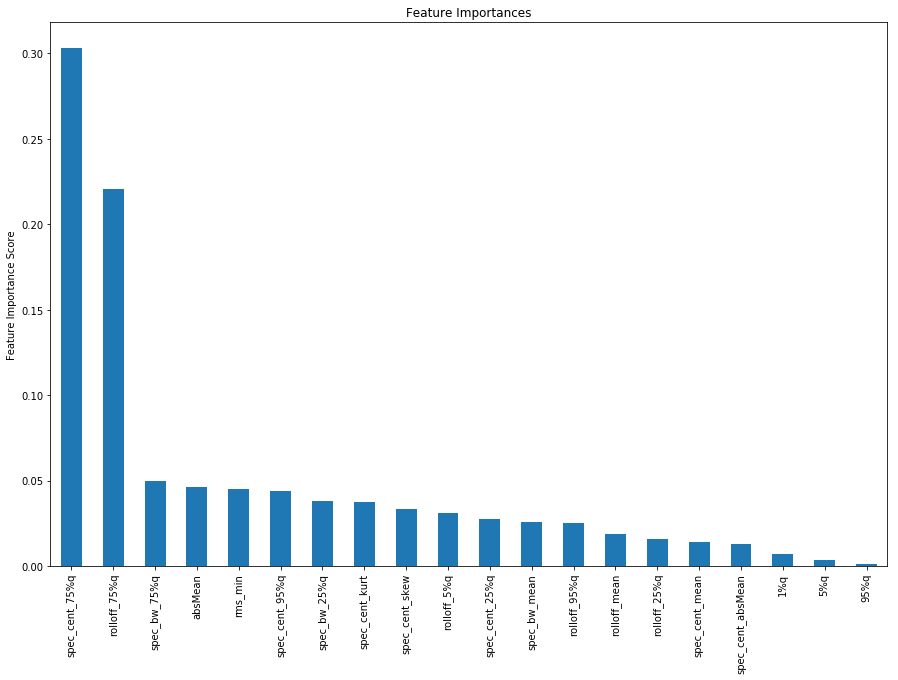

Top 20 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_bw_75%q', 'absMean', 'rms_min', 'spec_cent_95%q', 'spec_bw_25%q', 'spec_cent_kurt', 'spec_cent_skew', 'rolloff_5%q', 'spec_cent_25%q', 'spec_bw_mean', 'rolloff_95%q', 'rolloff_mean', 'rolloff_25%q', 'spec_cent_mean', 'spec_cent_absMean', '1%q', '5%q', '95%q']


In [13]:
gbm0 = RandomForestRegressor(random_state=10)
modelfit(gbm0, feature_data, time_to_failure)

# Parameter Tuning

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 5, 8, 10 ,15],
    'max_features': [15, 18,20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 200, 500, 1000]
}

In [11]:
n_estimators=100

### Tune max_depth and num_samples_split

In [15]:
param_test1 = {'max_depth':range(14,20,2), 'min_samples_split':range(5,20,2)}

gsearch1 = GridSearchCV(
    estimator = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_features='sqrt', 
        random_state=10), 
    param_grid = param_test1, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
gsearch1.fit(feature_data,time_to_failure)

print('Best params {}'.format(gsearch1.best_params_))
print('Best MAE score: {}'.format(gsearch1.best_score_))

Best params {'max_depth': 14, 'min_samples_split': 10}
Best MAE score: -1.8257132875848001


In [16]:
max_depth=14
min_samples_split=10

Tune min_samples_leaf

In [21]:
param_test2 = {'min_samples_leaf':range(2,13,2)}
gsearch2 = GridSearchCV(estimator = 
                        RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            max_features='sqrt', 
                            random_state=10), 
                            param_grid = 
                            param_test2,
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch2.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch2.best_params_))
print('Best MAE score: {}'.format(gsearch2.best_score_))

Best params {'min_samples_leaf': 2}
Best MAE score: -1.8229695760527869


In [ ]:
min_samples_leaf=80


Model Report
MAE train data: 1.445
CV Score MAE: 
Mean -1.82297 
Std 0.007425356 
Min -1.83746 
Max -1.816967


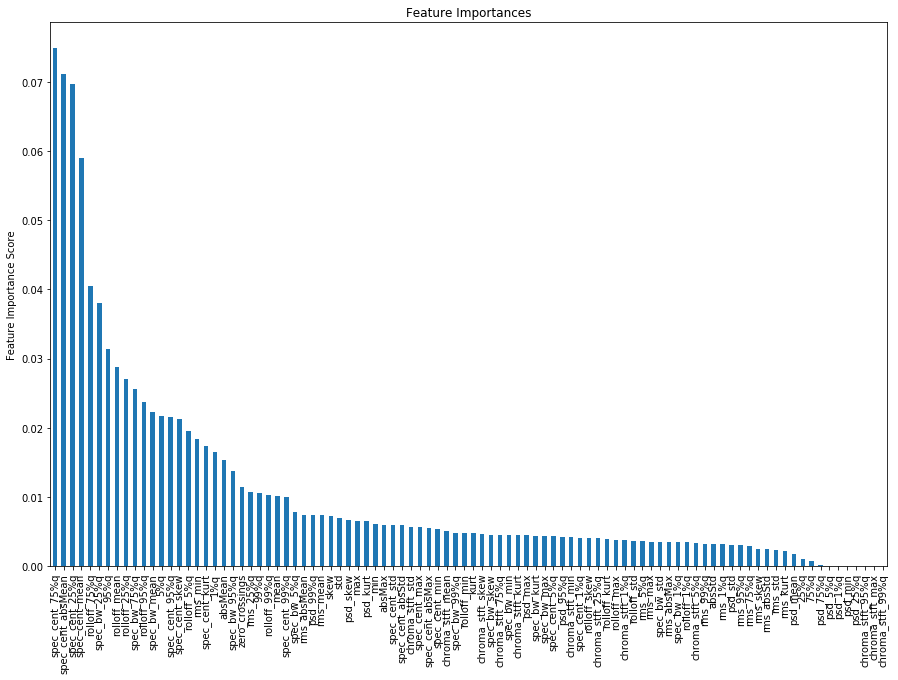

Top 30 Feature
['spec_cent_75%q', 'spec_cent_absMean', 'spec_cent_25%q', 'spec_cent_mean', 'rolloff_75%q', 'spec_bw_25%q', '95%q', 'rolloff_mean', 'rolloff_25%q', 'spec_bw_75%q', 'rolloff_95%q', 'spec_bw_mean', '5%q', 'spec_cent_95%q', 'spec_cent_skew', 'rolloff_5%q', 'rms_min', 'spec_cent_kurt', '1%q', 'absMean', 'spec_bw_95%q', 'zero_crossings', 'rms_25%q', '99%q', 'rolloff_99%q', 'mean', 'spec_cent_99%q', 'spec_bw_5%q', 'rms_absMean', 'psd_99%q']


In [22]:
modelfit(gsearch2.best_estimator_,  feature_data, time_to_failure)

In [ ]:
param_test3 = {'max_features':range(7,20,2)}
gsearch3 = GridSearchCV(estimator = 
                        RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth, 
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            random_state=10),
                            param_grid = param_test3, 
                            scoring='neg_mean_absolute_error',
                            iid=False,
                            n_jobs=-1,
                            cv=5)
gsearch3.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch3.best_params_))
print('Best MAE score: {}'.format(gsearch3.best_score_))

In [ ]:
max_features = 17

In [ ]:
param_test4 = {'n_estimators' :[200,500,1000,1500]}
gsearch4 = GridSearchCV(estimator = 
                        RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            random_state=10),
                        param_grid = param_test4,
                        scoring='neg_mean_absolute_error',
                        iid=False,
                        n_jobs=-1,
                        cv=5)

gsearch4.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch4.best_params_))
print('Best MAE score: {}'.format(gsearch4.best_score_))

In [ ]:
modelfit(gsearch4.best_estimator_,  feature_data, time_to_failure)

In [ ]:
param_test5 = {'criterion' :['mae','mse']}
gsearch5 = GridSearchCV(estimator = 
                        RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features=max_features,
                            random_state=10),
                        param_grid = param_test5,
                        scoring='neg_mean_absolute_error',
                        iid=False,
                        n_jobs=-1,
                        cv=5)

gsearch6.fit(feature_data,time_to_failure)
print('Best params {}'.format(gsearch5.best_params_))
print('Best MAE score: {}'.format(gsearch5.best_score_))

In [ ]:
modelfit(gsearch5.best_estimator_,  feature_data, time_to_failure)